<p style="font-family: verdana;font-size: 28px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">0. TABLE OF CONTENT</p>
    

* [<p style="font-family: verdana;font-size: 18px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">1. Introduction</p>](#index1)
* [<p style="font-family: verdana;font-size: 18px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">2. Importing libraries and datasets</p>](#index2)
* [<p style="font-family: verdana;font-size: 18px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">3. Data preprocessing</p>](#index3)
* [<p style="font-family: verdana;font-size: 18px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">4. EDA</p>](#index4)
* [<p style="font-family: verdana;font-size: 18px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">5. Feature Engineering</p>](#index5)

<hr style="height: 0.5px; border: 0; background-color: 'Black'">


![sales](https://cdn.dribbble.com/users/1503100/screenshots/4115965/untitled-3.gif)

<a id="index1"></a>
# <p style="font-family: verdana;font-size: 28px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">1. INTRODUCTION</p>

<p style="font-family: verdana;font-size: 18px">For this project, I'll be working with "Womart," leading nutrition and supplement retail chain that offers a comprehensive range of products for wellness and fitness needs.</p> 

<p style="font-family: verdana;font-size: 18px">The purpose of this notebook will be to predict the number of sales for each store to provide the stores with essential insights into the upcoming inventory and cash flow for the following months. </p>

<p style="font-family: verdana;font-size: 18px">The dataset that they provided contains the information of sales of the past 18 months along with:</p>

* <p style="font-family: verdana;font-size: 18px">ID: Unique identifier for a row</p>

* <p style="font-family: verdana;font-size: 18px">Store id: Unique id for each store</p>

* <p style="font-family: verdana;font-size: 18px">Store type: Type of the store</p>

* <p style="font-family: verdana;font-size: 18px">Location type: Type of the location where the store is located</p>

* <p style="font-family: verdana;font-size: 18px">Region Code: Code of the region where the store is located</p>

* <p style="font-family: verdana;font-size: 18px">Date: Information about the date</p>

* <p style="font-family: verdana;font-size: 18px">Holiday: If there is a holiday on the given date</p>

* <p style="font-family: verdana;font-size: 18px">Discount: If the store offers a discount on the given date</p>

<p style="font-family: verdana;font-style: bold;font-size: 18px">NOTE: Work in progress. Notebook not finished.</p>

<hr style="height: 0.5px; border: 0; background-color: 'Black'">

<a id="index2"></a>
# <p style="font-family: verdana;font-size: 28px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">2. IMPORTING LIBRARIES AND DATASETS</p>

In [1]:
# Downloading the necesary libraries
!pip install proplot

# Importing the necesary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import proplot as pplt                       # Fonts 
from scipy import stats                      # Remove outliers
import matplotlib.ticker as ticker           # Modify axis
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split



import warnings
warnings.filterwarnings('ignore') 

     |████████████████████████████████| 8.0 MB 21.2 MB/s 


/opt/conda/lib/python3.7/site-packages/proplot/__init__.py:71: ProPlotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


In [2]:
# Importing data
train = pd.read_csv('../input/supplement-sales-prediction/TRAIN.csv')
test = pd.read_csv('../input/supplement-sales-prediction/TEST_FINAL.csv')
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


<hr style="height: 0.5px; border: 0; background-color: 'Black'">

<a id="index3"></a>
# <p style="font-family: verdana;font-size: 28px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">3. DATA PREPROCESSING</p>

## <p style="font-family: verdana;font-size: 23px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">3.1 Rename Values</p>

In [3]:
# Rename the values on "Discount" 
train['Discount'] = train['Discount'].map({'Yes': 1, 'No': 0})

## <p style="font-family: verdana;font-size: 23px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">3.2 Data Types</p>

In [4]:
# Data types
print('Data type per variable:')
print(train.dtypes)

Data type per variable:
ID                object
Store_id           int64
Store_Type        object
Location_Type     object
Region_Code       object
Date              object
Holiday            int64
Discount           int64
#Order             int64
Sales            float64
dtype: object


In [5]:
# Changing data types
train[['Store_id', 'Holiday', 'Discount']] = train[['Store_id', 'Holiday', 'Discount']].astype(object)
train['Date'] = pd.to_datetime(train.Date)

## <p style="font-family: verdana;font-size: 23px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">3.3 Duplicates and Missing Values</p>

In [6]:
# Do we have duplicates?
print('Number of duplicates:', len(train[train.duplicated()]))

# Do we have missing values?
print('Number of missing values:', train.isnull().sum().sum())

Number of duplicates: 0
Number of missing values: 0


<a id="index4"></a>
# <p style="font-size: 28px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">4. EDA</p>

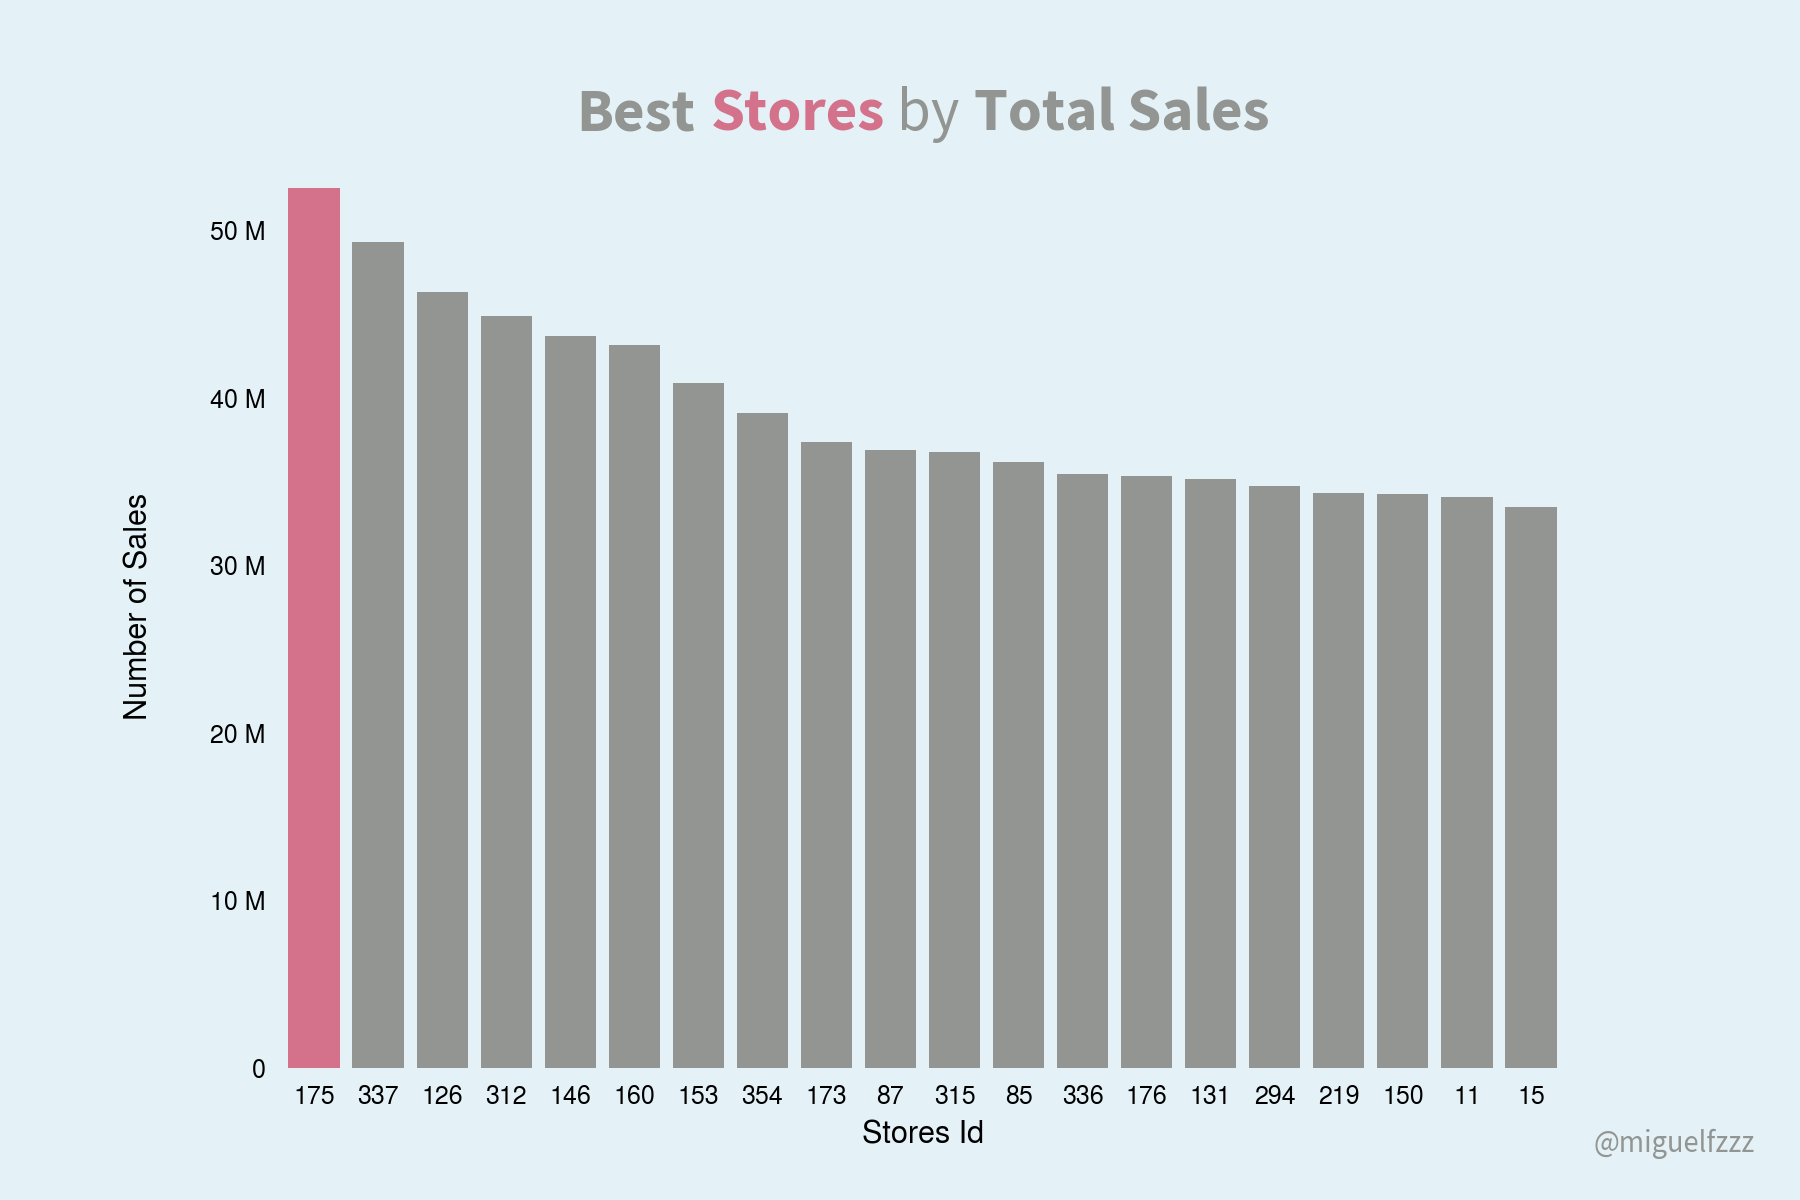

In [7]:
# Which are the best stores (by number of sells)?
best_stores = train.groupby(['Store_id'], as_index=False)['Sales'].sum()        # sum sales from same store
best_stores = best_stores.sort_values('Sales', ascending = False)                # sort data
best_stores = best_stores.head(20)                                               # select top 20
best_stores['Store_id'] = best_stores['Store_id'].astype(str)

# Visualization
fig, ax = plt.subplots(figsize =(9, 6))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

# For changing colors
col1 = best_stores.head(1)
col2 = best_stores.tail(19)

ax.bar(col1.Store_id, col1.Sales, color = '#d4728c')
ax.bar(col2.Store_id, col2.Sales, color = 'grey')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Setting thousands with k
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Y axis position
ax.spines['left'].set_position(('data', -0.5))

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

# Labels titles
plt.xlabel('Stores Id', fontsize=11)
plt.ylabel('Number of Sales', fontsize=11, labelpad=20)

# Title
plt.text(4.1, 56000000, "Best", size=22, color="grey", fontweight="bold")
plt.text(6.2, 56000000, "Stores", size=22, color="#d4728c", fontweight="bold")
plt.text(9.1, 56000000, "by", size=22, color="grey")
plt.text(10.3, 56000000,"Total Sales", size=22, color="grey", fontweight="bold")

# Author
plt.text(22.5, -5000000, "@miguelfzzz", fontsize=11, ha="right", color='grey');

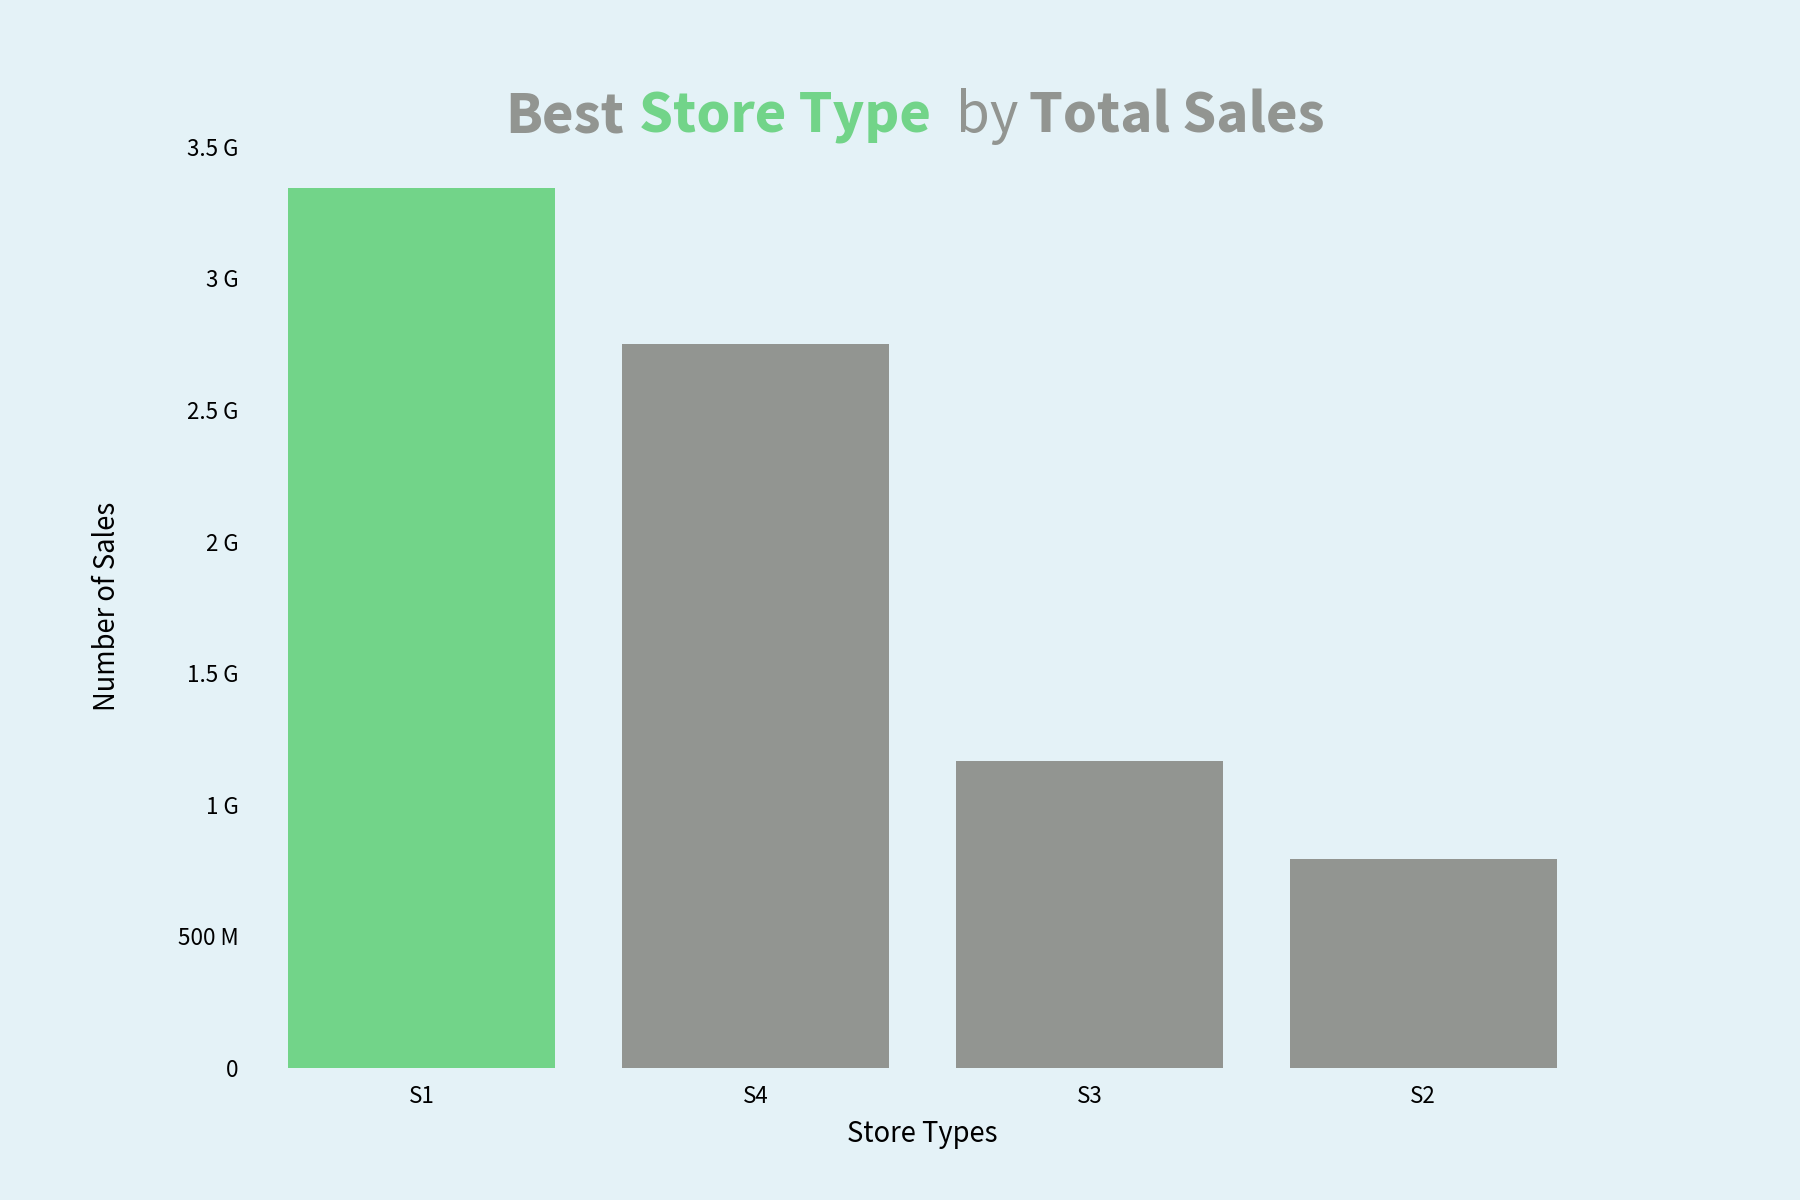

In [8]:
# Which are the best store types (by number of sales)?
best_store_type = train.groupby(['Store_Type'], as_index=False)['Sales'].sum()    
best_store_type = best_store_type.sort_values('Sales', ascending = False)                  
best_store_type['Store_Type'] = best_store_type['Store_Type'].astype(str)

# Visualization
fig, ax = plt.subplots(figsize =(9, 6))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

# For changing colors
col1 = best_store_type.head(1)
col2 = best_store_type.tail(3)

ax.bar(col1.Store_Type, col1.Sales, color = '#72d489')
ax.bar(col2.Store_Type, col2.Sales, color = 'grey')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Setting thousands with k
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Y axis position
ax.spines['left'].set_position(('data', -0.5))

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

# Labels titles
plt.xlabel('Store Types', fontsize=11)
plt.ylabel('Number of Sales', fontsize=11, labelpad=20)

# Title
plt.text(0.25, 3555000000, "Best", size=22, color="grey", fontweight="bold")
plt.text(0.65, 3555000000, "Store Type", size=22, color="#72d489", fontweight="bold")
plt.text(1.6, 3555000000, "by", size=22, color="grey")
plt.text(1.82, 3555000000,"Total Sales", size=22, color="grey", fontweight="bold")

# Author
plt.text(22.5, -5000000, "@miguelfzzz", fontsize=11, ha="right", color='grey');

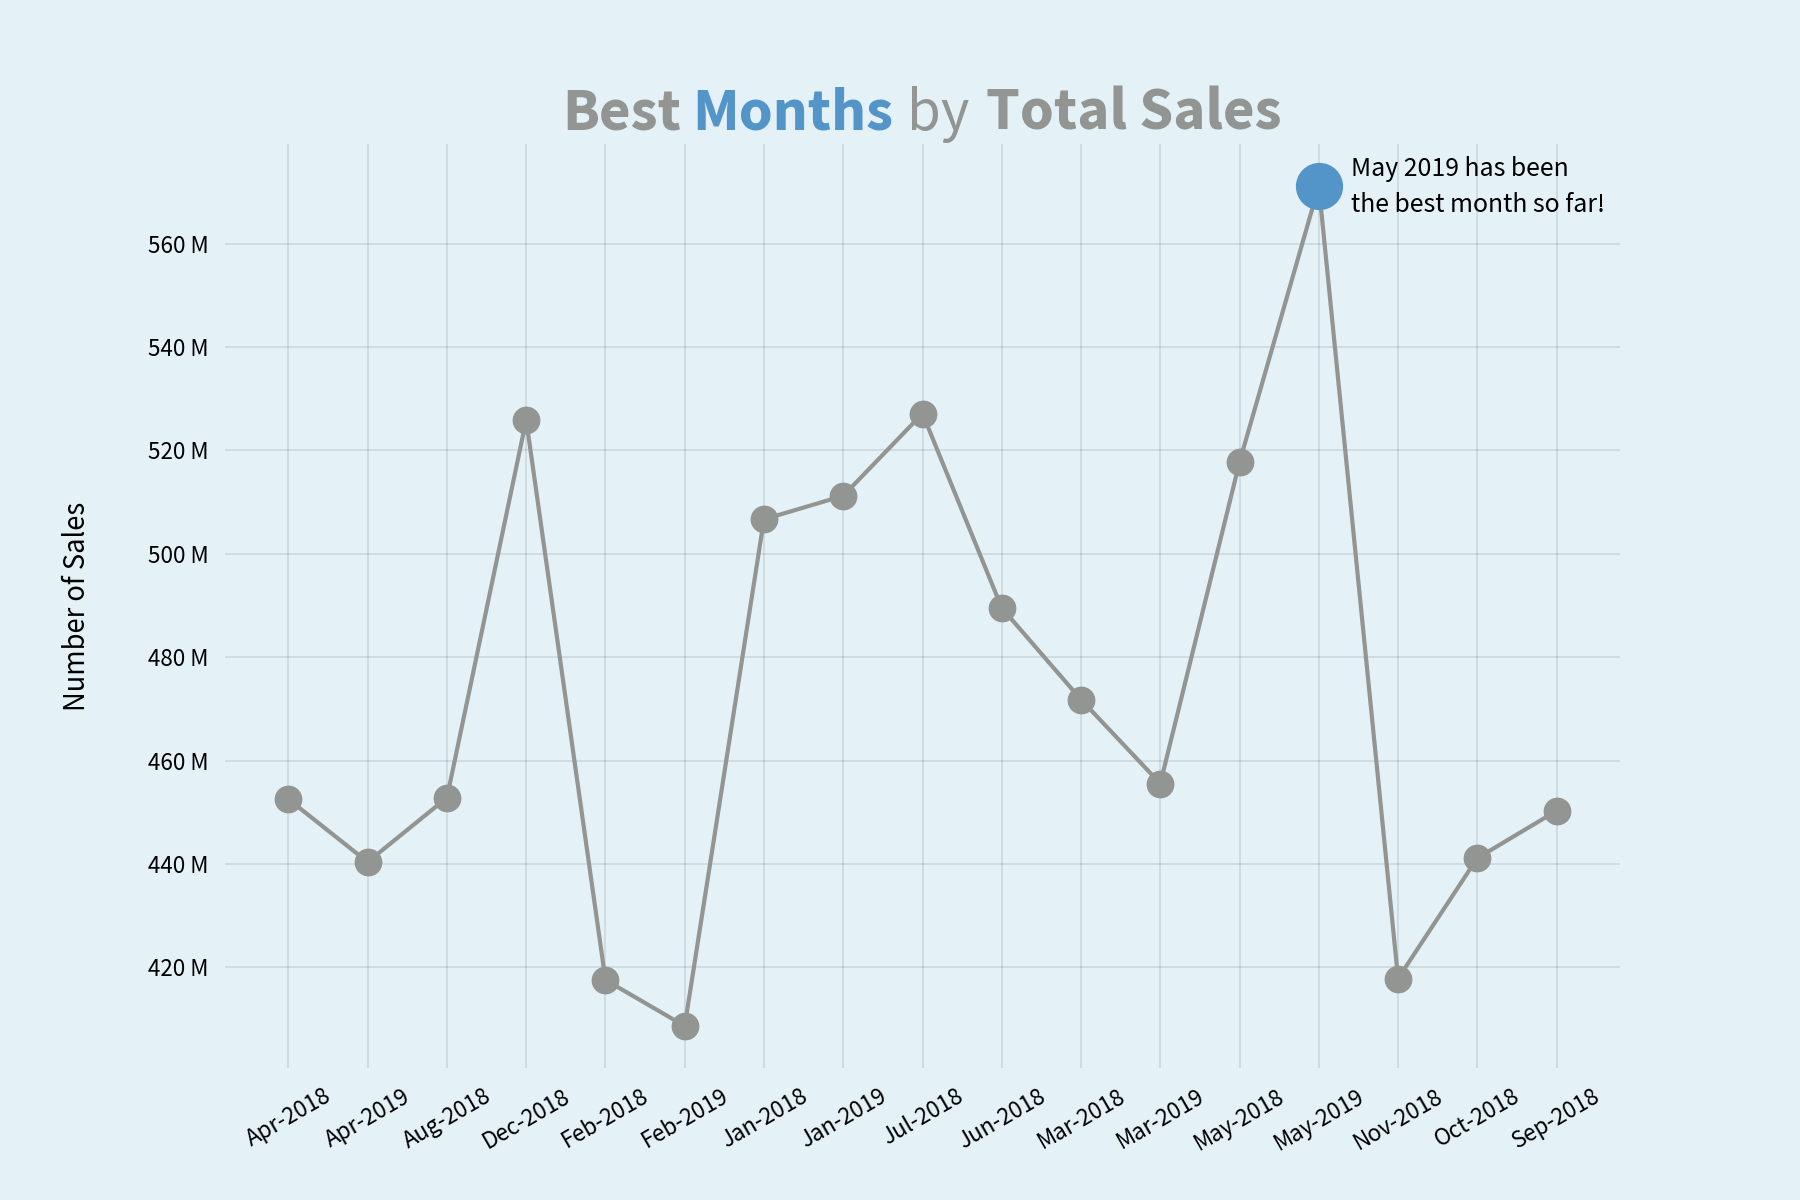

In [9]:
# Best months by sells
best_month = train.copy()
best_month['Month'] = best_month['Date'].apply(lambda x: x.strftime('%b-%Y')) 
best_month = best_month.groupby(['Month'], as_index=False)['Sales'].sum()  

# Visualization
fig, ax = plt.subplots(figsize =(9, 6))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

best_month_1 = best_month.sort_values('Sales', ascending = False).head(1)

ax.plot(best_month.Month, best_month.Sales, marker='o', markerfacecolor='grey', color = 'gray', markersize=9)
ax.plot(best_month_1.Month, best_month_1.Sales, marker='o', markerfacecolor='#5495c9', color = '#5495c9', markersize=16)

plt.xticks(rotation=30)

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Setting thousands with k
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

# Labels titles
plt.ylabel('Number of Sales', fontsize=11, labelpad=20)

# Annotations
plt.text(13.4, 573000000, "May 2019 has been", size=10)
plt.text(13.4, 566000000, "the best month so far!", size=10)


# Title
plt.text(3.45, 582000000, "Best", size=22, color="grey", fontweight="bold")
plt.text(5.1, 582000000, "Months", size=22, color="#5495c9", fontweight="bold")
plt.text(7.8, 582000000, "by", size=22, color="grey")
plt.text(8.8, 582000000,"Total Sales", size=22, color="grey", fontweight="bold")

# Author
plt.text(38, 43000, "@miguelfzzz", fontsize=11, ha="right", color='grey');

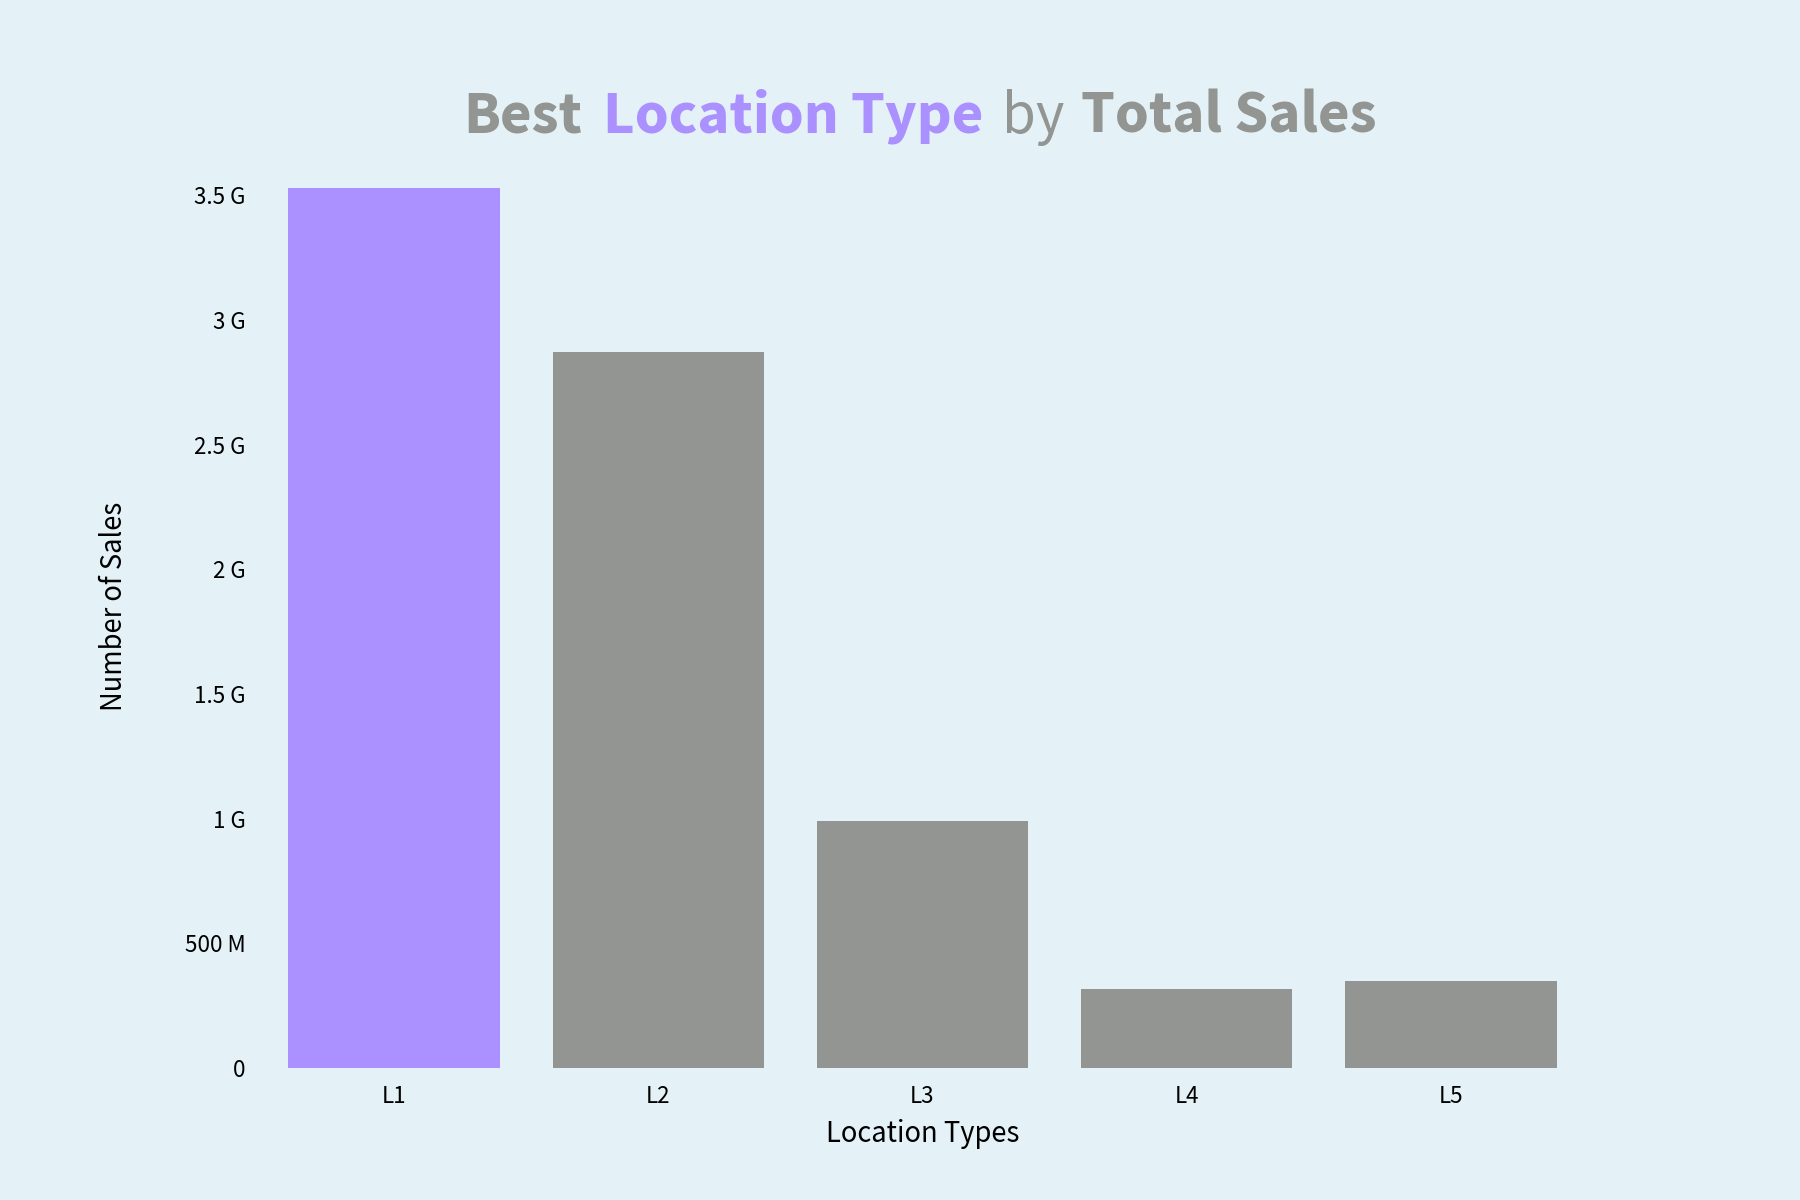

In [10]:
# Which are the best locations (by number of sales)?
best_location = train.groupby(['Location_Type'], as_index=False)['Sales'].sum()    
best_location['Location_Type'] = best_location['Location_Type'].astype(str)

# Visualization
fig, ax = plt.subplots(figsize =(9, 6))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

# For changing colors
col1 = best_location.head(1)
col2 = best_location.tail(4)

ax.bar(col1.Location_Type, col1.Sales, color = '#ab90ff')
ax.bar(col2.Location_Type, col2.Sales, color = 'grey')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Setting thousands with k
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Y axis position
ax.spines['left'].set_position(('data', -0.5))

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

# Labels titles
plt.xlabel('Location Types', fontsize=11)
plt.ylabel('Number of Sales', fontsize=11, labelpad=20)

# Title
plt.text(0.26, 3750000000, "Best", size=22, color="grey", fontweight="bold")
plt.text(0.79, 3750000000, "Location Type", size=22, color="#ab90ff", fontweight="bold")
plt.text(2.3, 3750000000, "by", size=22, color="grey")
plt.text(2.6, 3750000000,"Total Sales", size=22, color="grey", fontweight="bold")

# Author
plt.text(22.5, -5000000, "@miguelfzzz", fontsize=11, ha="right", color='grey');

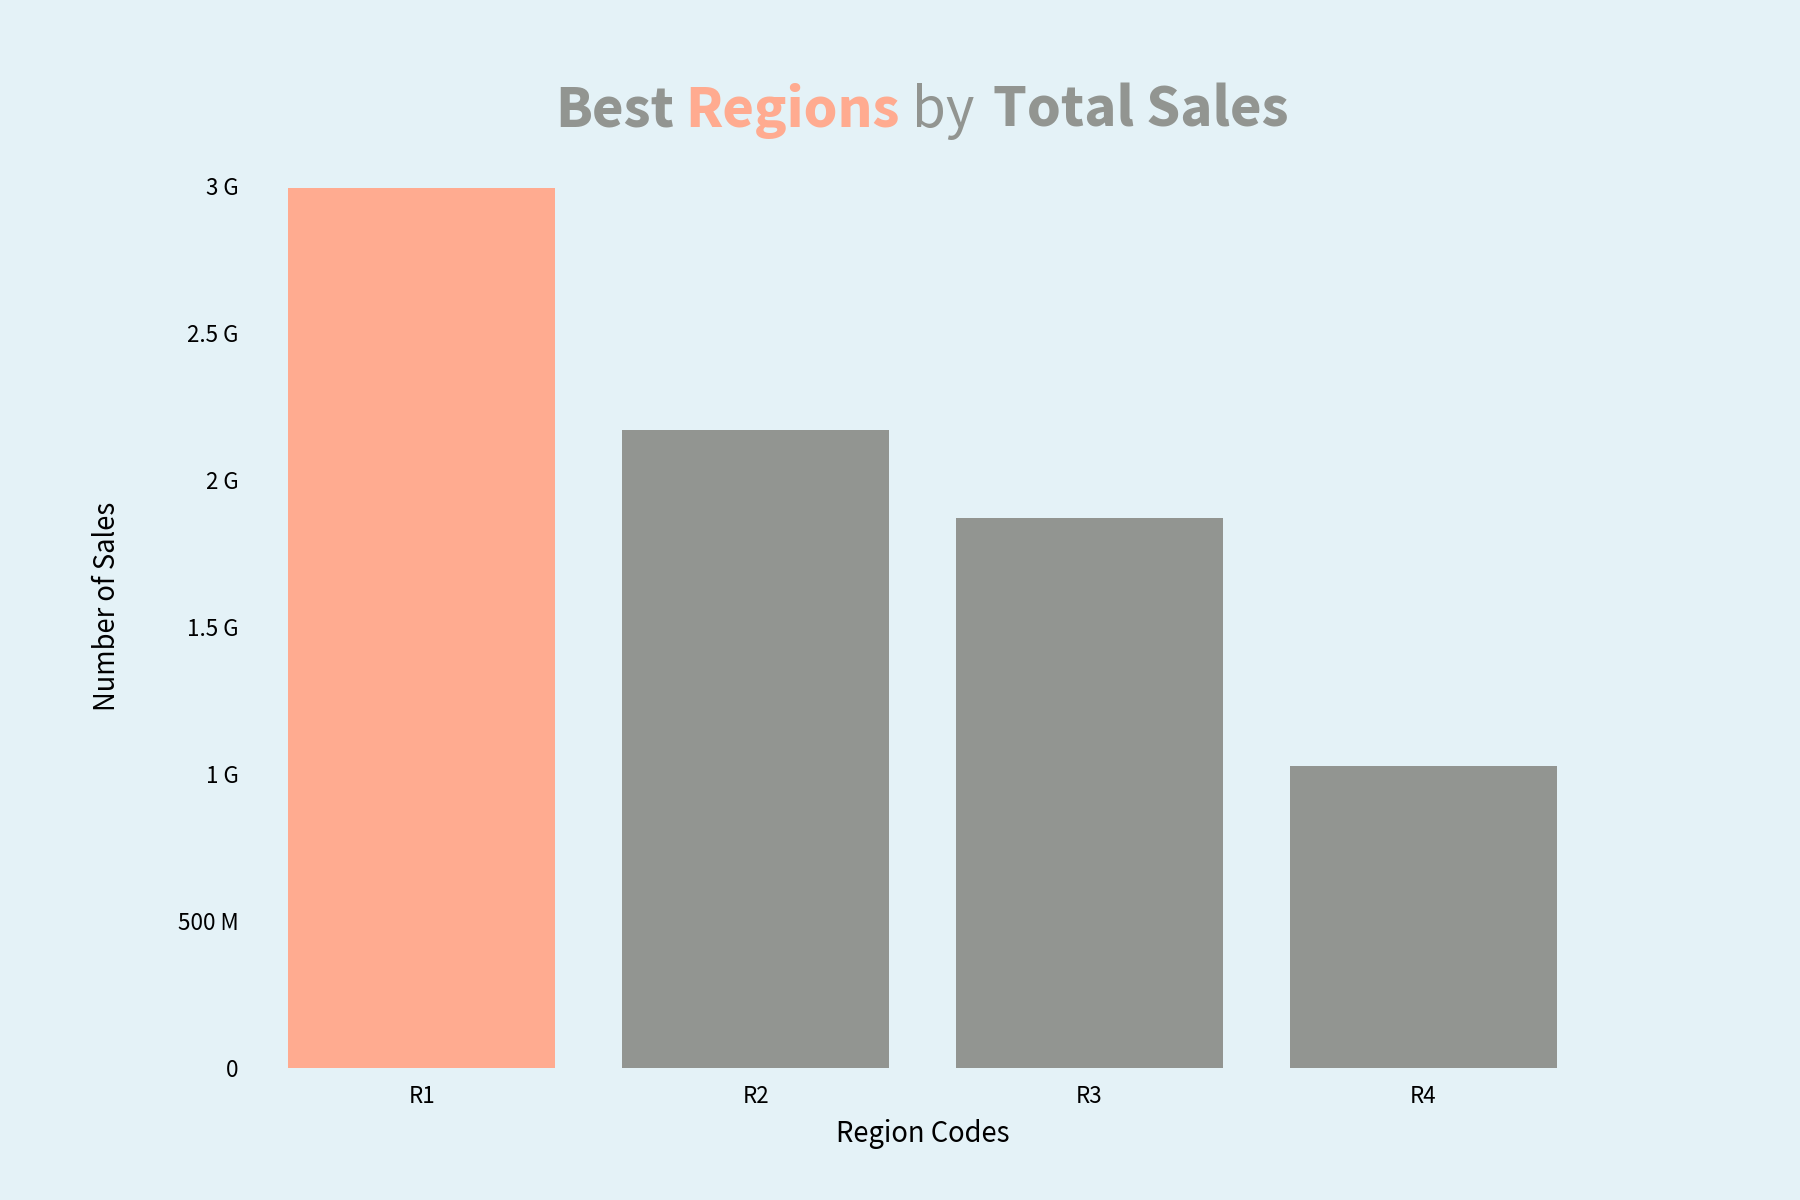

In [11]:
# Which are the best regions (by number of sales)?
best_region = train.groupby(['Region_Code'], as_index=False)['Sales'].sum()    
best_region['Region_Code'] = best_region['Region_Code'].astype(str)

# Visualization
fig, ax = plt.subplots(figsize =(9, 6))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

# For changing colors
col1 = best_region.head(1)
col2 = best_region.tail(3)

ax.bar(col1.Region_Code, col1.Sales, color = '#ffab90')
ax.bar(col2.Region_Code, col2.Sales, color = 'grey')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Setting thousands with k
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Y axis position
ax.spines['left'].set_position(('data', -0.5))

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

# Labels titles
plt.xlabel('Region Codes', fontsize=11)
plt.ylabel('Number of Sales', fontsize=11, labelpad=20)

# Title
plt.text(0.4, 3200000000, "Best", size=22, color="grey", fontweight="bold")
plt.text(0.79, 3200000000, "Regions", size=22, color="#ffab90", fontweight="bold")
plt.text(1.47, 3200000000, "by", size=22, color="grey")
plt.text(1.71, 3200000000,"Total Sales", size=22, color="grey", fontweight="bold")

# Author
plt.text(22.5, -5000000, "@miguelfzzz", fontsize=11, ha="right", color='grey');

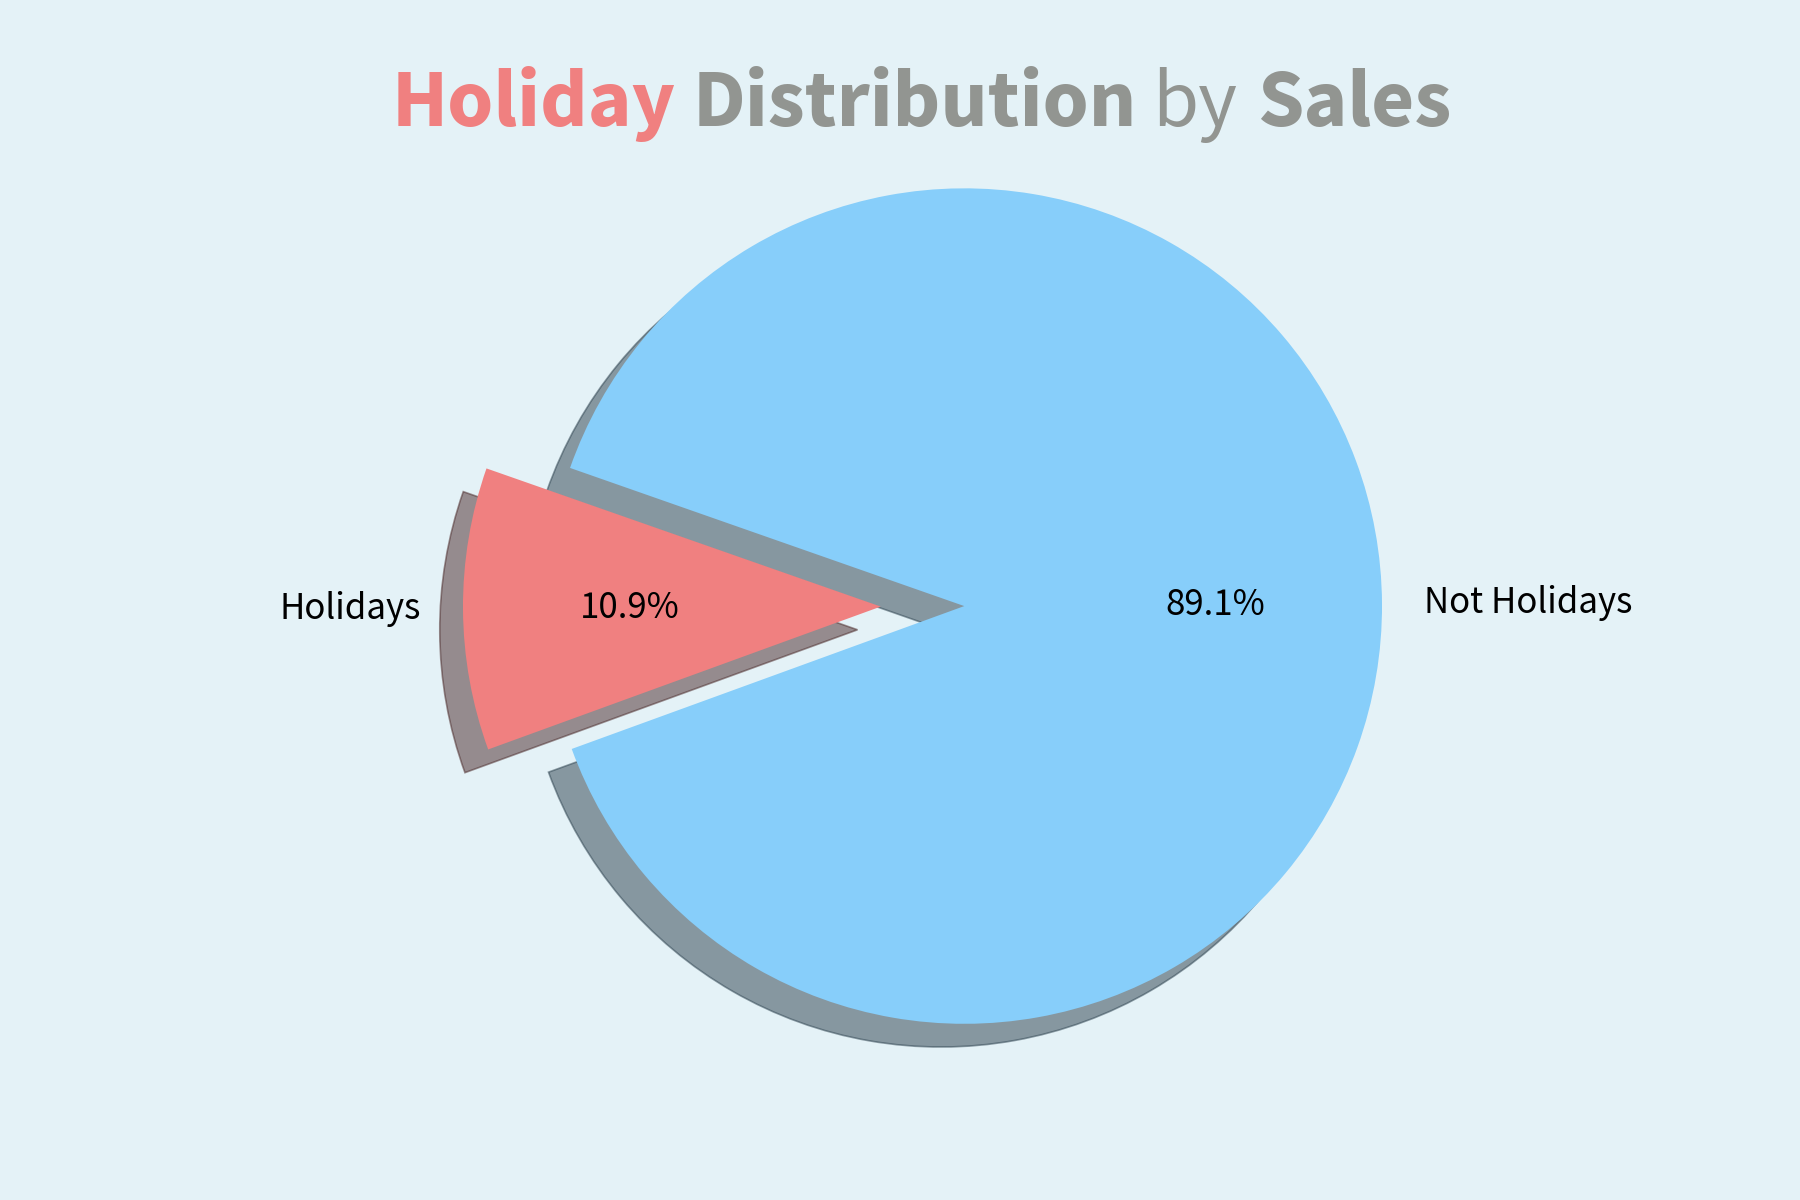

In [12]:
# Holidays Distribution
holiday = train.groupby(['Holiday'], as_index=False)['Sales'].sum()    
holiday['Holiday'] = holiday['Holiday'].astype(str)

# Visualization
fig = plt.figure(figsize =(9, 6))
fig.patch.set_facecolor('#e4f2f7')

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Source Sans Pro'

plt.pie(holiday['Sales'], 
        explode=(0.2, 0), 
        labels=['Not Holidays', 'Holidays'], 
        colors= ['lightskyblue', 'lightcoral'],
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=200)
        
plt.axis('equal')

plt.text(-1.17, 1.15, "Holiday", size=30, color="lightcoral", fontweight="bold")
plt.text(-0.45, 1.15, "Distribution", size=30, color="grey", fontweight="bold")
plt.text(0.65, 1.15, "by", size=30, color="grey")
plt.text(0.9, 1.15, "Sales", size=30, color="grey", fontweight="bold")

plt.show()

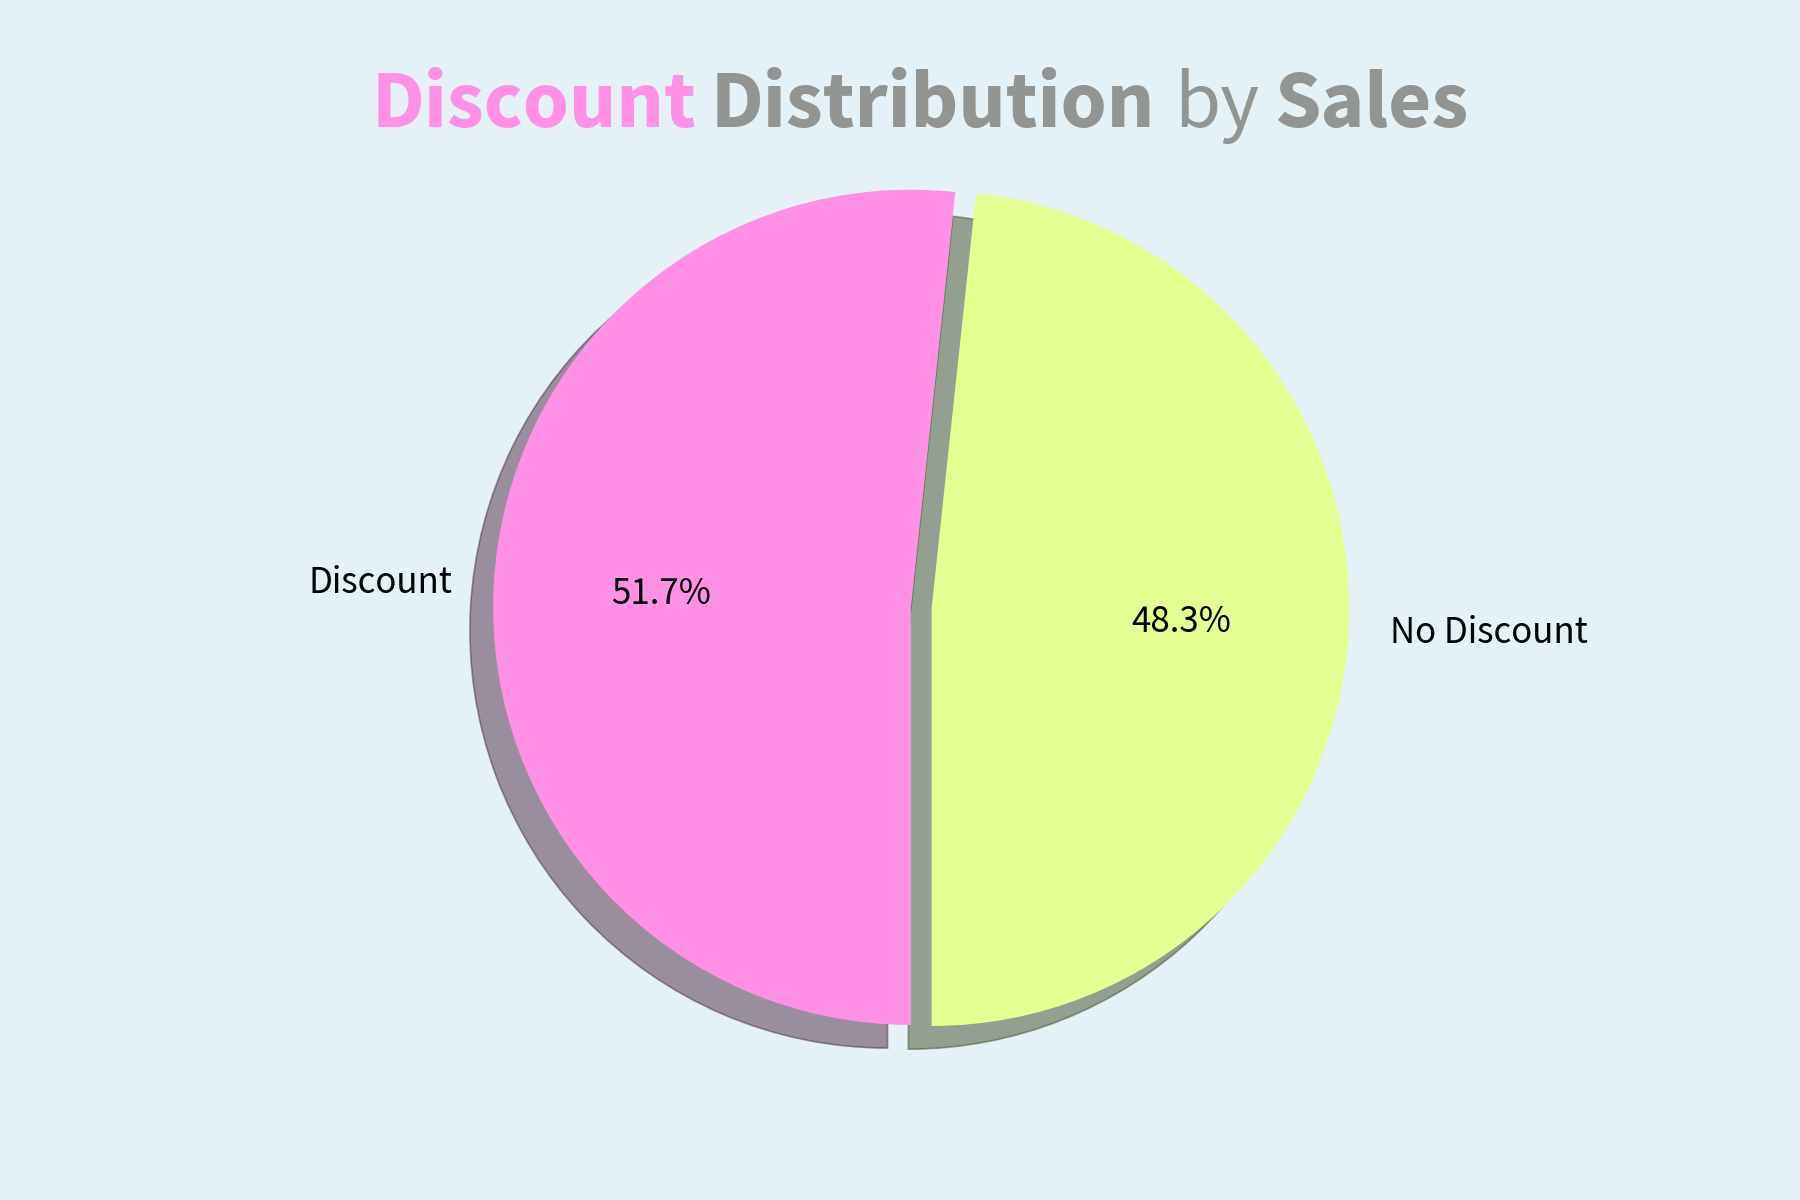

In [13]:
# Discount distribution
discount = train.groupby(['Discount'], as_index=False)['Sales'].sum()    
discount['Discount'] = discount['Discount'].astype(str)
discount.head()

# Visualization
fig = plt.figure(figsize =(9, 6))
fig.patch.set_facecolor('#e4f2f7')

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Source Sans Pro'

plt.pie(discount['Sales'], 
        labels=['No Discount', 'Discount'], 
        explode=(0.05, 0),
        colors= ['#e4ff90', '#ff90e4'],
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=270)
        
plt.axis('equal')

plt.text(-1.29, 1.15, "Discount", size=30, color="#ff90e4", fontweight="bold")
plt.text(-0.48, 1.15, "Distribution", size=30, color="grey", fontweight="bold")
plt.text(0.63, 1.15, "by", size=30, color="grey")
plt.text(0.87, 1.15, "Sales", size=30, color="grey", fontweight="bold")

plt.show()


<a id="index5"></a>
# <p style="font-size: 28px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">5. FEATURE ENGINEERING</p>

In [14]:
# Let's check the data again
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,1,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,1,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,1,62,45614.52


## 5.1 ID

The "ID" column will be useless for our prediction, so I'll drop it.

In [15]:
# Remove "ID" 
train = train.drop('ID', 1)

## 5.2 Changing data types for the model

In [16]:
# Data types
print('Data type per variable:')
print(train.dtypes)

Data type per variable:
Store_id                 object
Store_Type               object
Location_Type            object
Region_Code              object
Date             datetime64[ns]
Holiday                  object
Discount                 object
#Order                    int64
Sales                   float64
dtype: object


In [17]:
train[['Store_id','Holiday', 'Discount']] = train[['Store_id', 'Holiday', 'Discount']].astype(int)

## 5.3 Categorical variables

For the categorical variables, I'm going to transform them into dummies variables. This process is known as "One-Hot Encoding."

In [18]:
categ_cols = train.dtypes[train.dtypes == np.object]  # filtering by categorical variables
categ_cols = categ_cols.index.tolist()     # list of categorical fields
train = pd.get_dummies(train, columns=categ_cols, drop_first=True)   # One hot encoding

## 5.4 Date

In [19]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day_of_week'] = train['Date'].dt.dayofweek
train['Weekday'] = train['Date'].dt.weekday
train['Quarter'] = train['Date'].dt.quarter

train = train.drop(['Date'], axis = 1) 

train = pd.get_dummies(train, columns=['Year'], drop_first=True, prefix='Year')
train = pd.get_dummies(train, columns=['Month'], drop_first=True, prefix='Month')
train = pd.get_dummies(train, columns=['Day_of_week'], drop_first=True, prefix='Day_of_week')
train = pd.get_dummies(train, columns=['Weekday'], drop_first=True, prefix='Weekday')
train = pd.get_dummies(train, columns=['Quarter'], drop_first=True, prefix='Quarter')

train.head()

,Store_id,Holiday,Discount,#Order,Sales,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L2,Location_Type_L3,...,Day_of_week_6,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Quarter_2,Quarter_3,Quarter_4
0,1,1,1,9,7011.84,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,253,1,1,60,51789.12,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,252,1,1,42,36868.20,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,251,1,1,23,19715.16,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,250,1,1,62,45614.52,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## 5.5 Target's correlations 

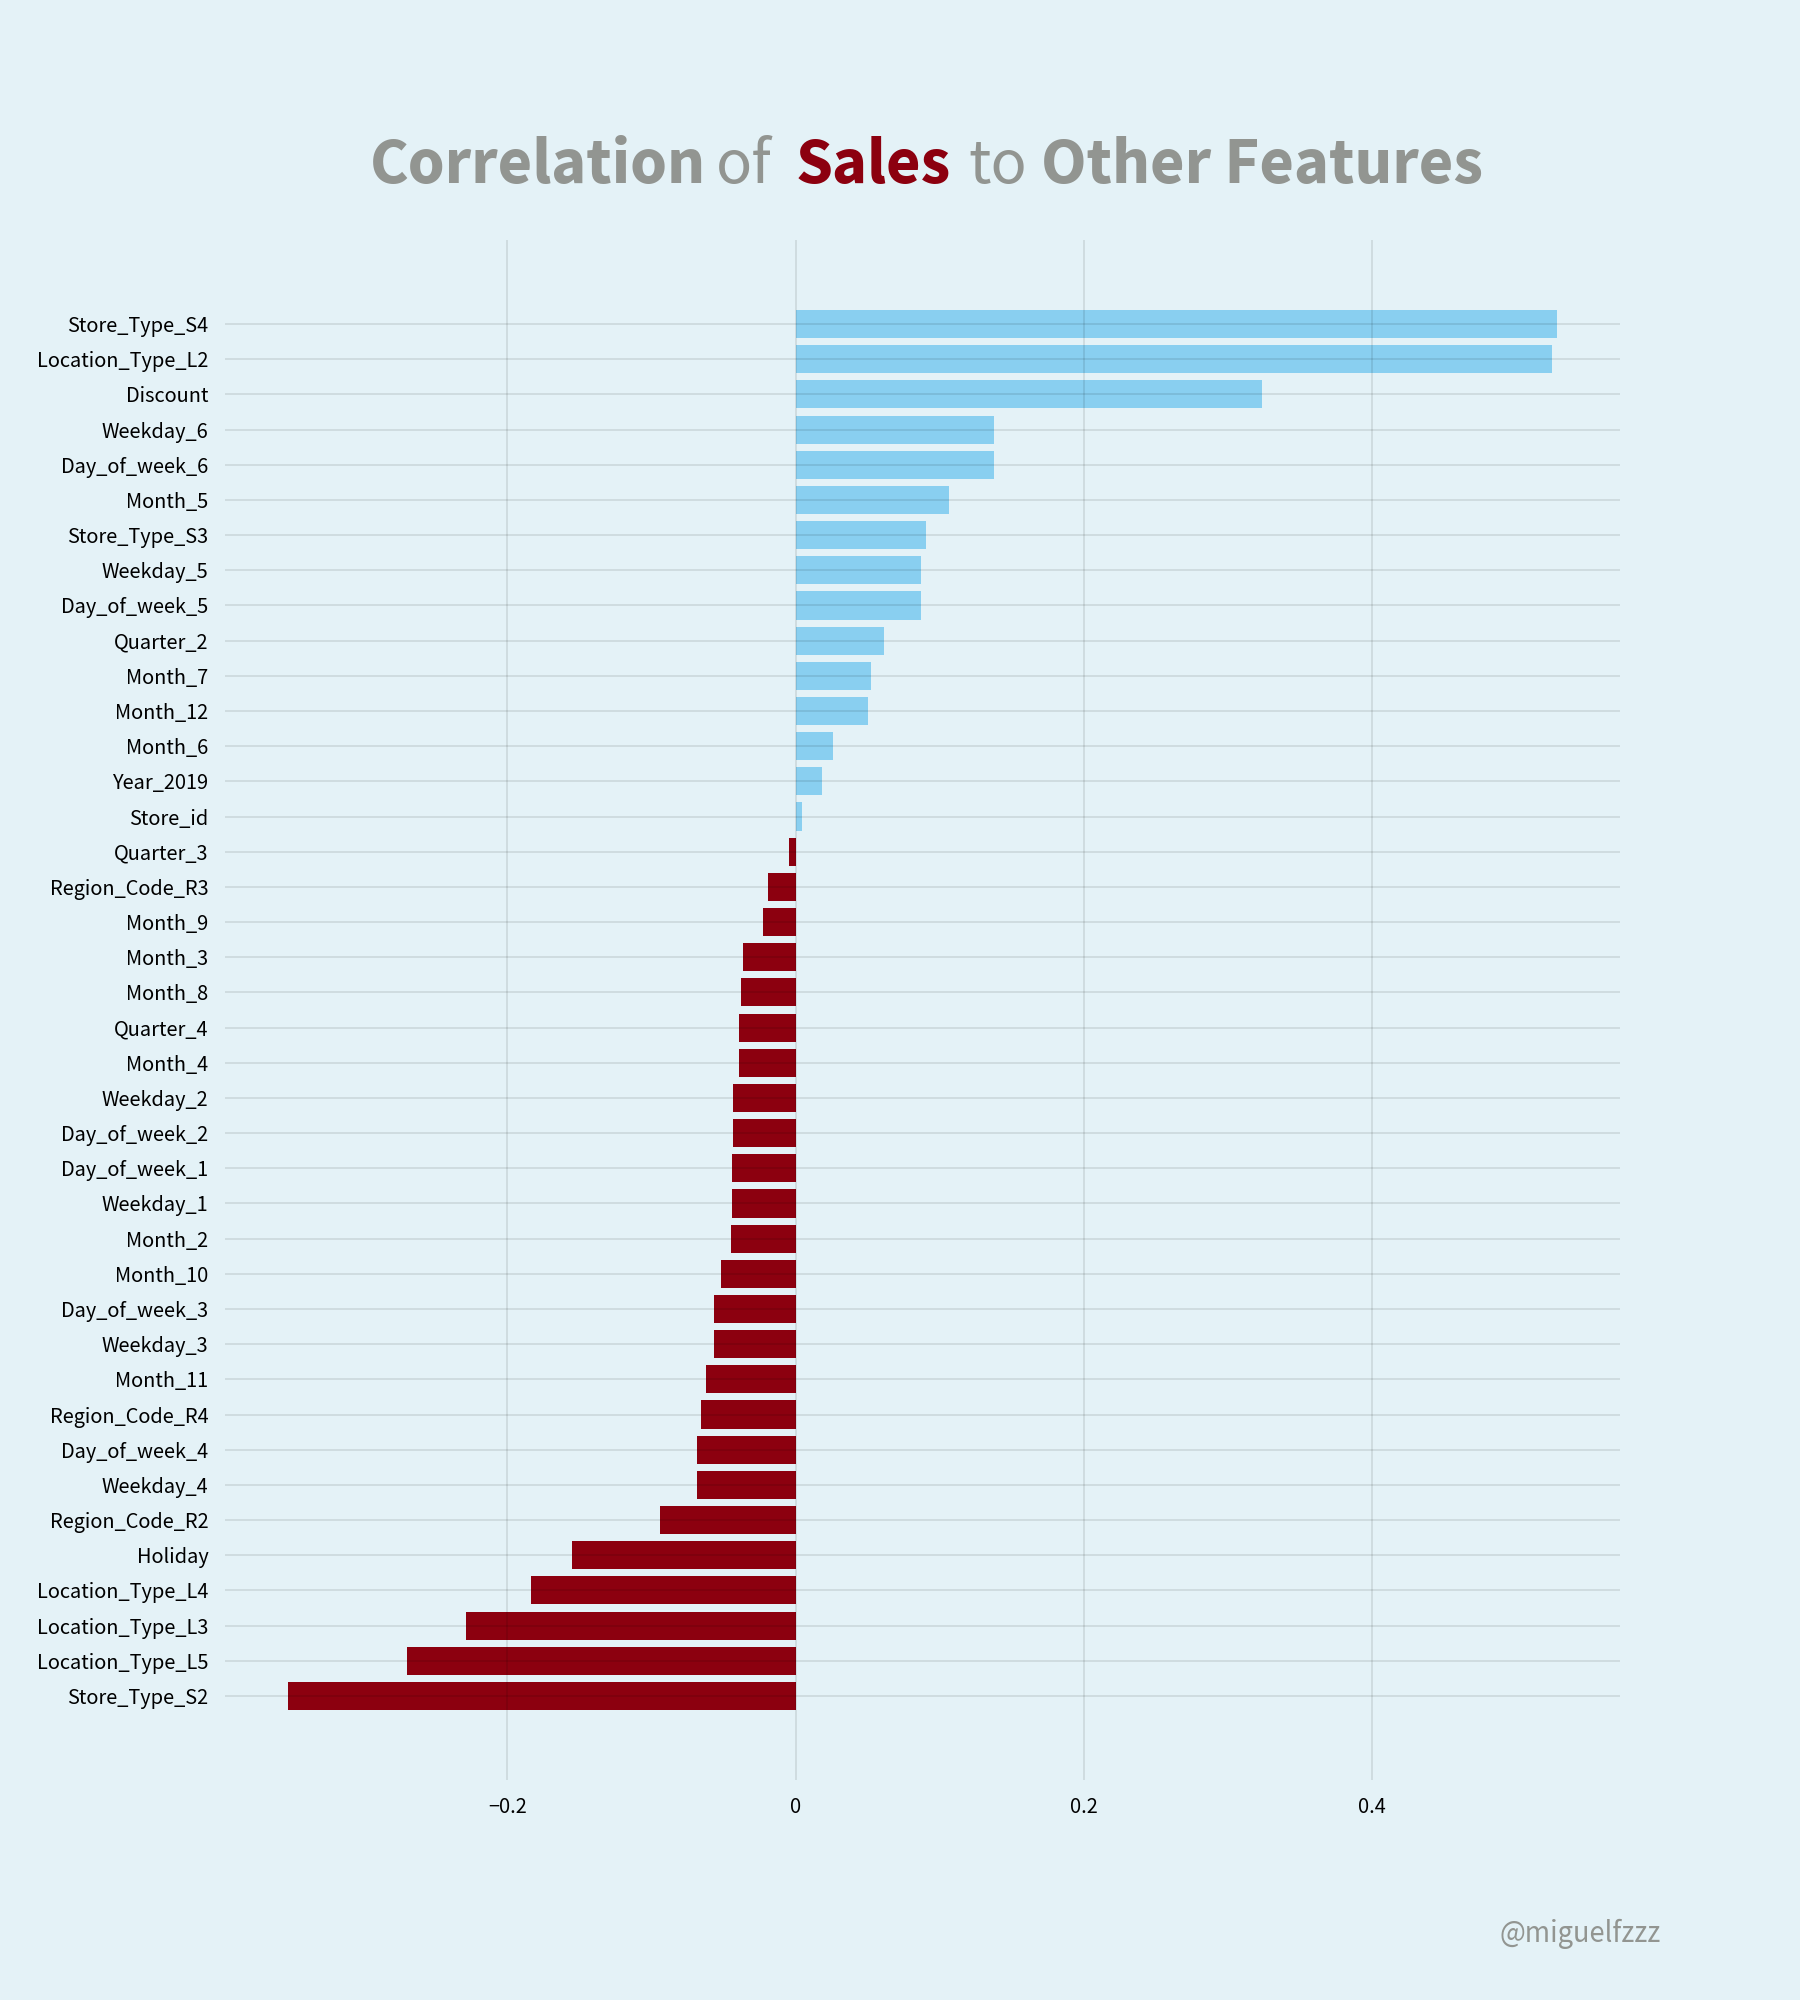

In [20]:
corr = train[train.columns].corr()['Sales'][:].sort_values(ascending=True).to_frame()
corr = corr.drop(corr[corr.Sales > 0.90].index)

# Visualization
fig, ax = plt.subplots(figsize =(9, 10))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

ax.barh(corr.index, corr.Sales, align='center', color = np.where(corr['Sales'] < 0, 'crimson', '#89CFF0'))

ax.tick_params(axis='both', which='major', labelsize=8)
ax.yaxis.set_label_coords(0, 0)

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

plt.text(-0.295, 43, "Correlation", size=24, color="grey", fontweight="bold");
plt.text(-0.055, 43, "of", size=24, color="grey");
plt.text(0, 43, "Sales", size=24, color="crimson", fontweight="bold");
plt.text(0.12, 43, "to", size=24, color="grey");
plt.text(0.17, 43, "Other Features", size=24, color="grey", fontweight="bold");

# Author
plt.text(0.6, -7, "@miguelfzzz", fontsize=11, ha="right", color='grey');

* Now we can remove the variables with low correlation. In my case, I'm going to remove the year and store id.

In [21]:
del train['Store_id']
del train['Year_2019']

## 5.6 Sales

### Outliers

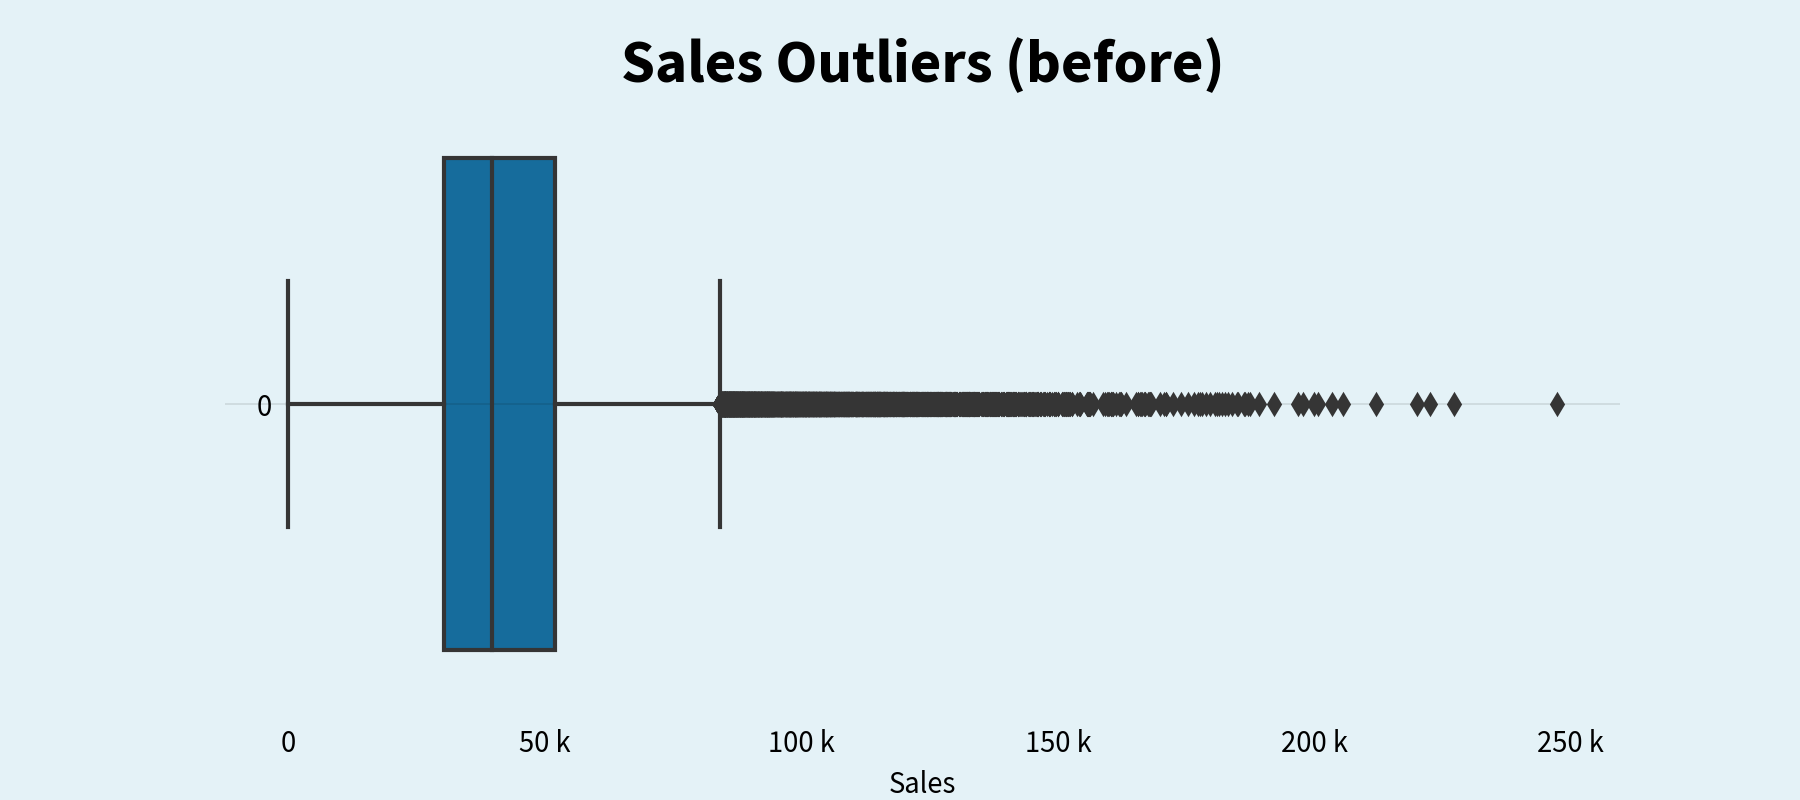

In [22]:
# Visualization
fig, ax = plt.subplots(figsize =(9, 4))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

sns.boxplot(train.Sales);

ax.tick_params(axis='both', which='major', labelsize=11)

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Setting thousands with k
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.xaxis.set_major_formatter(ticker.EngFormatter())

# Y axis position
ax.spines['left'].set_position(('data', -0.5))

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

plt.xlabel('Sales', fontsize=11);

plt.title('Sales Outliers (before)', size=22, fontweight="bold");

In [23]:
# Dealing with the outliers
q1 = train['Sales'].quantile(0.25)
q3 = train['Sales'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['Sales'])
for i in train['Sales']:
    if i > Upper_tail or i < Lower_tail:
            train['Sales'] = train['Sales'].replace(i, med)

# I took the code from this notebook -> https://www.kaggle.com/nareshbhat/outlier-the-silent-killer

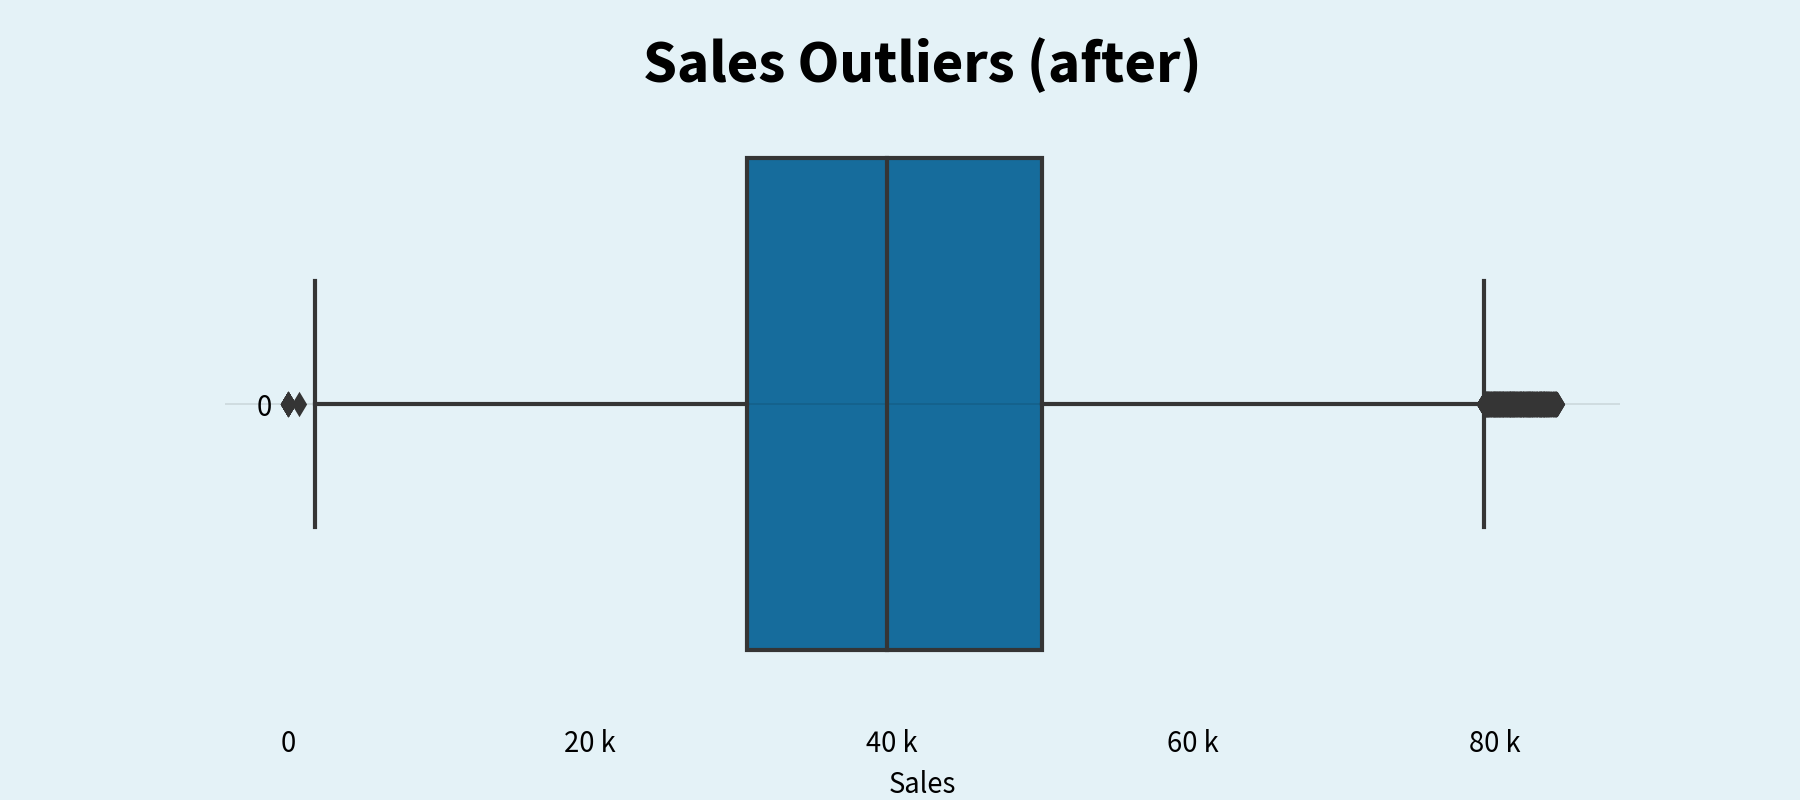

In [24]:
# Visualization
fig, ax = plt.subplots(figsize =(9, 4))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

sns.boxplot(train['Sales']);

ax.tick_params(axis='both', which='major', labelsize=11)

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Setting thousands with k
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.xaxis.set_major_formatter(ticker.EngFormatter())

# Y axis position
ax.spines['left'].set_position(('data', -0.5))

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

plt.xlabel('Sales', fontsize=11);

plt.title('Sales Outliers (after)', size=22, fontweight="bold");

### Scaling target variable

In [25]:
# Normalization on Sales
train['Sales'] = MinMaxScaler().fit_transform(np.array(train['Sales']).reshape(-1,1))

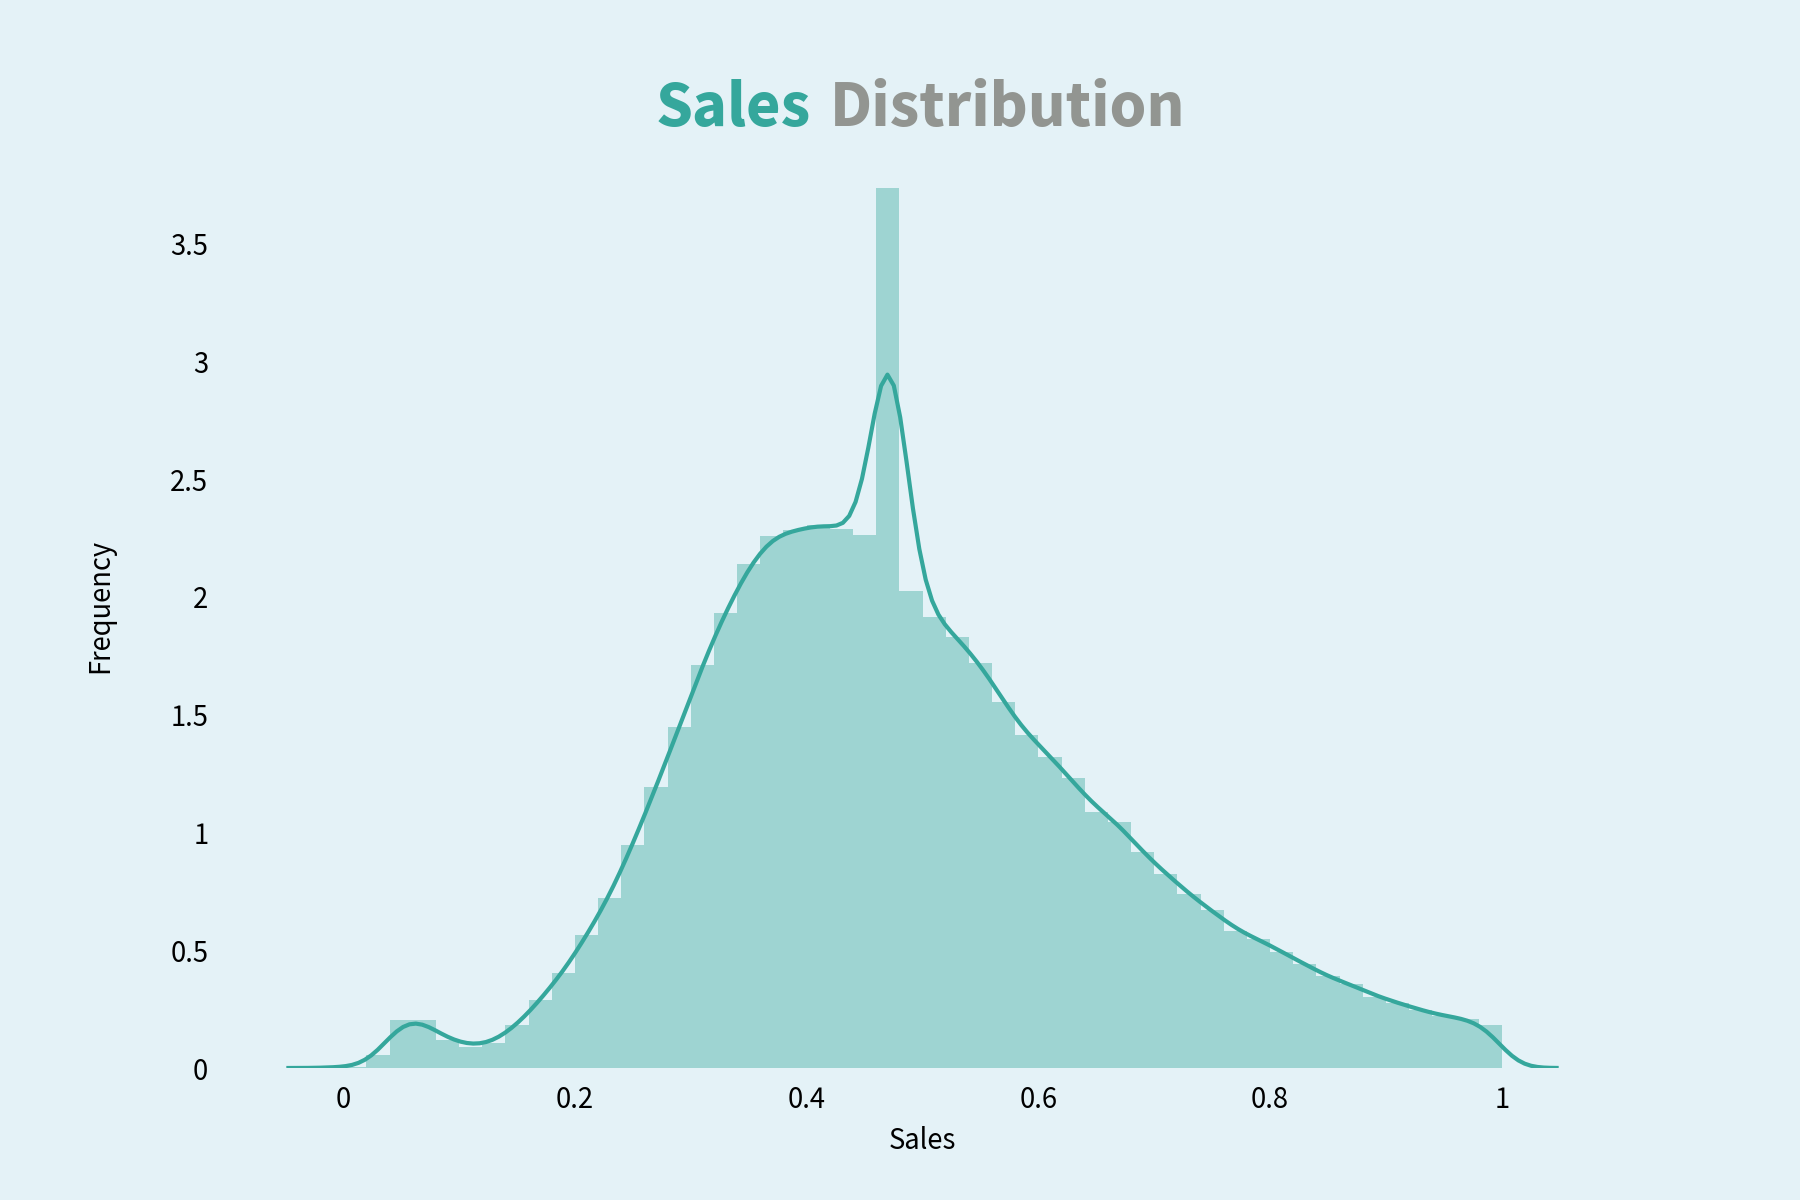

In [26]:
# Visualization
fig, ax = plt.subplots(figsize =(9, 6))
fig.patch.set_facecolor('#e4f2f7')
ax.patch.set_facecolor('#e4f2f7')

sns.distplot(train['Sales'], color="#35a79c");

ax.tick_params(axis='both', which='major', labelsize=11)

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(False)

# Remove grid
plt.grid(b=None)

# Y axis position

# Font
mpl.rcParams['font.family'] = 'Source Sans Pro'

# Labels titles
plt.xlabel('Sales', fontsize=11)
plt.ylabel('Frequency', fontsize=11, labelpad=20);

plt.text(0.27, 4, "Sales", size=24, color="#35a79c", fontweight="bold");
plt.text(0.42, 4, "Distribution", size=24, color="grey", fontweight="bold");

# Author
plt.text(285000, -3000, "@miguelfzzz", fontsize=11, ha="right", color='grey');

# <p style="font-size: 28px;font-style: bold; letter-spacing: 2px; color: grey; line-height:1.0">6. PREDICTION MODEL</p>

<font size="5">Work in progress... If you liked it so far, please don't forget to comment and upvote. Thank you!</font>
